# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.interpolate import interp1d
from scipy.optimize import minimize
sys.path.append('documents/BNL/jupyter/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='drive/'
from algorithms import  Comb, Calibrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load in luseepy
current_dir = os.getcwd()

# Get the path to BNL/jupyter directory
jupyter_dir = os.path.abspath(os.path.join(current_dir, '../..'))
# Append the jupyter directory to the system path
sys.path.append(jupyter_dir)

import luseepy
from luseepy import lusee

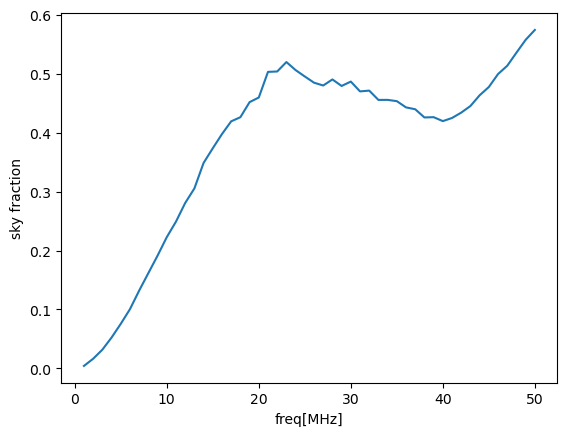

In [4]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




Text(0, 0.5, 'sky brightness [W/m^2/Hz/sr]')

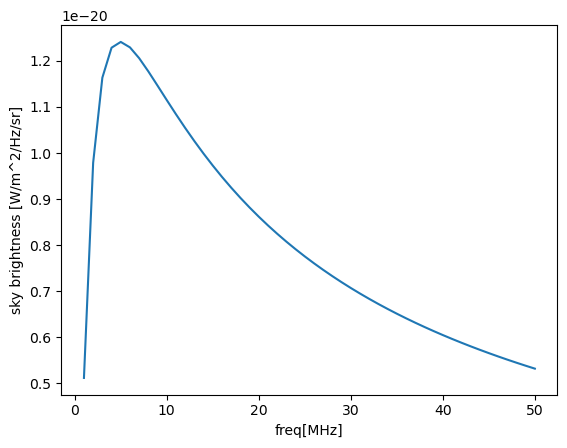

In [5]:
plt.plot(B.freq,lusee.MonoSkyModels.B_NB(B.freq))
plt.xlabel('freq[MHz]')
plt.ylabel('sky brightness [W/m^2/Hz/sr]')

Power per tone 4.999999999999999e-19 W/m^2


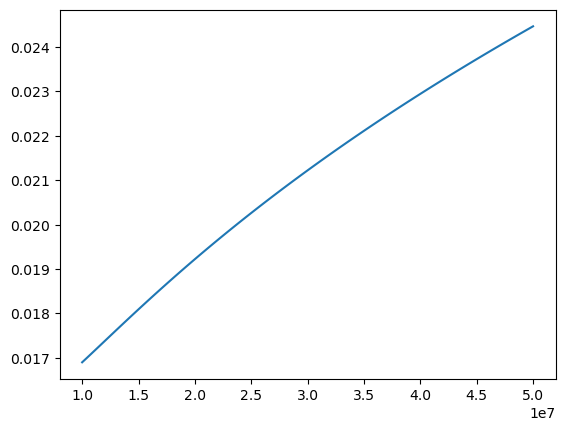

In [6]:
# define signal and sky signals
req_level = 5e-24 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

def signal_rms(freq):
    freq_MHz = freq/1e6
    sf = sky_fraction(freq_MHz)
    return np.sqrt(req_level*sf)

def noise_rms(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area
    return np.sqrt(sky_signal)

freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal_rms(freq)/noise_rms(freq))
#plt.plot(freq,noise(freq))

In [7]:
precompensation = np.load('precompensation.npz')['precomp']
antenna = 1/np.copy(precompensation)
x= np.arange(512)

init_params = [230, 20]


def pwr_filt(x, center, width): # power filter
    return 1 + 60 * np.exp(-(x - center)**2 / (2 * width**2))

def func(params): # define function for maximizing
    center, width = params
    modifier = pwr_filt(x, center, width)
    precompensation_fix = precompensation * modifier
    precompensation_fix /= np.sum(precompensation_fix)  # Normalize the filter
    boosted_signal = precompensation_fix * antenna
    return -np.sum(boosted_signal)  # Negate because we use minimize

# Perform the optimization
result = minimize(func, init_params, bounds=[(0, 511), (1, 100)])
optm_center, optm_width = result.x
optm_modifier = pwr_filt(x, optm_center, optm_width)

print(f"Optimized Center: {optm_center}, Optimized Width: {optm_width}")

Optimized Center: 207.08081850095226, Optimized Width: 22.25212489443238


In [9]:
precompensation_fix = precompensation * optm_modifier
precompensation_fix/=precompensation_fix.sum()
precompensation.sum()

0.999996529940528

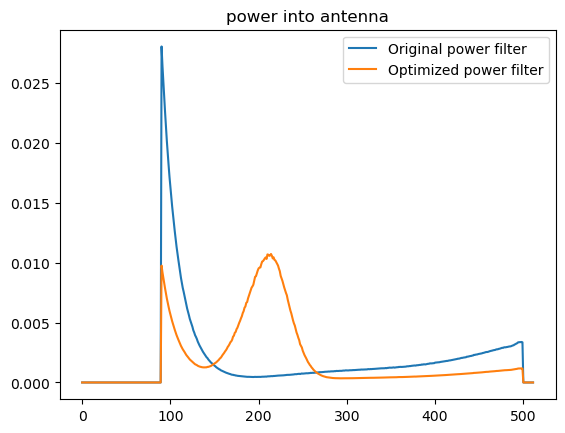

In [13]:
plt.title('power into antenna')
plt.plot(x, precompensation, label='Original power filter')
plt.plot(x, precompensation_fix, label='Optimized power filter')
plt.legend()


2.6212032695060046


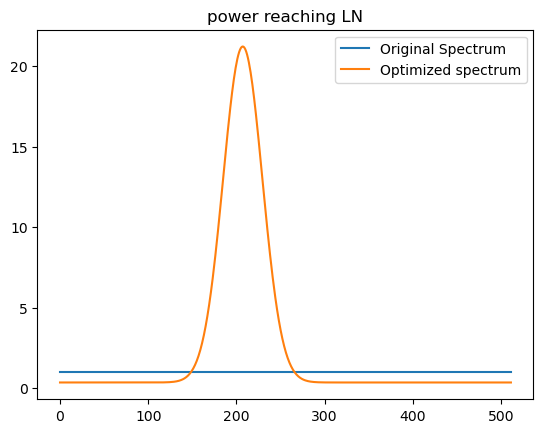

In [15]:
plt.title('power reaching LN')
plt.plot(precompensation*antenna,label='Original Spectrum')
plt.plot(precompensation_fix*antenna,label='Optimized spectrum')
plt.legend()
print ((precompensation_fix*antenna).sum()/(precompensation*antenna).sum())

In [ ]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms, precompensation=precompensation_fix, antenna=antenna)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=128)
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=-0.3,tmax=3,force_detect=True)
res['detect'], res['SNRdBdet']

In [ ]:
plt.plot(res['t'], res['alphadet'])
plt.ylim(-1.3,1.3)

print('rms=',res['alphadet'].std())

In [ ]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms,pilot_idx=[300],pilot_boost=15)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

In [ ]:
plt.plot(nb/wb)
